In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import gpplot as gpp 
gpp.set_aesthetics(context = 'paper')

#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42


In [2]:
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)


Pandas version: 2.2.2
Numpy version: 1.26.4


In [3]:
inPath = "../Data/PrimaryLibrary/processed_z_score/"
merged_df = pd.read_csv(inPath + "inHouseDatasetsCombined.csv")

merged_df['detailedCategory'] = np.where(merged_df['Target Gene Symbol'].str.contains('NO_SITE'), 'No Site Control',
                   np.where(merged_df['Target Gene Symbol'].str.contains('ONE_INTERGENIC'), 'One Intergenic Control', 
                            merged_df['Category']))
merged_df['detailedCategory'].value_counts()

detailedCategory
Essential                 59553
Non-essential             45316
One Intergenic Control      993
No Site Control             990
Name: count, dtype: int64

In [4]:
figure1_outpath = '../Figure/Figure 1/Individual Figures/'

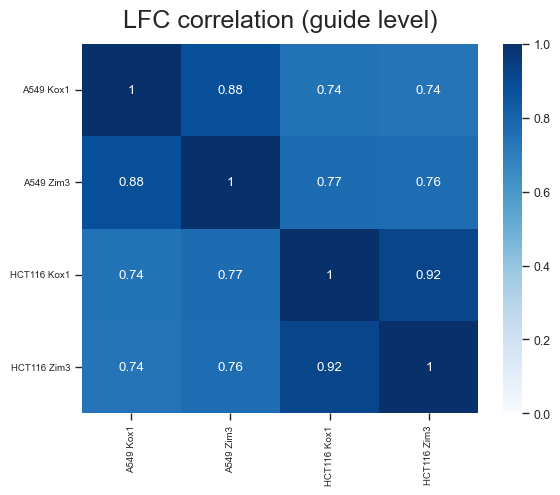

In [59]:
labels = ['A549 Kox1', 'A549 Zim3', 'HCT116 Kox1', 'HCT116 Zim3']
guide_heatmap = sns.heatmap(merged_df[['avg_lfc_A549_Kox1', 'avg_lfc_A549_Zim3', 'avg_lfc_HCT116_Kox1', 'avg_lfc_HCT116_Zim3',]].corr(), 
            annot=True, vmin=0, vmax=1, cmap='Blues',xticklabels=labels,yticklabels=labels)
guide_heatmap.set_title('LFC correlation (guide level)', fontdict={'fontsize':18}, pad=12)
plt.xticks(rotation=90,fontsize=7)
plt.yticks(rotation=0,fontsize=7)
gpp.savefig(figure1_outpath+'GuideLevelLFCHeatmap_test.pdf', dpi=300, bbox_inches='tight')



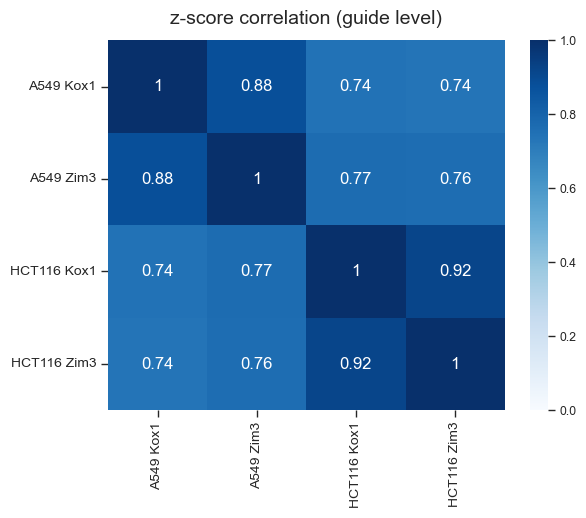

In [60]:
guide_heatmap = sns.heatmap(merged_df[['z_scored_avg_lfc_A549_Kox1', 'z_scored_avg_lfc_A549_Zim3', 
                                       'z_scored_avg_lfc_HCT116_Kox1', 'z_scored_avg_lfc_HCT116_Zim3']]\
                                     .rename(columns={'z_scored_avg_lfc_A549_Zim3': "A549 Zim3", 
                                                      "z_scored_avg_lfc_A549_Kox1": "A549 Kox1", 
                                                      "z_scored_avg_lfc_HCT116_Zim3": "HCT116 Zim3",
                                                     "z_scored_avg_lfc_HCT116_Kox1": "HCT116 Kox1"}).corr(), 
            annot=True, 
            annot_kws={"size": 12}, vmin=0, vmax=1, cmap='Blues')
guide_heatmap.set_title('z-score correlation (guide level)', fontdict={'fontsize':14}, pad=12)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(rotation=0,fontsize=10)
gpp.savefig(figure1_outpath+'GuideLevelZscoreHeatmap.pdf', dpi=300, bbox_inches='tight')



In [63]:
lfc_columns = merged_df.columns[merged_df.columns.str.startswith('avg_lfc')].tolist()
plot_df = merged_df[['Category'] + lfc_columns].melt(id_vars = 'Category', var_name = 'condition', value_name = 'Average LFC')
plot_df['condition'] = plot_df['condition'].str.split('_',expand=True)[2] + ' ' + plot_df['condition'].str.split('_',expand=True)[3]

plot_df = plot_df[~plot_df['Category'].str.contains('INTERGENIC')]

In [64]:
ssmd_df = plot_df.groupby(['condition','Category']).agg(mean = ('Average LFC','mean'),
                                              std = ('Average LFC','std')).reset_index()
ssmd_df = ssmd_df.pivot(columns = 'Category', index = 'condition', values = ['mean','std']).reset_index()
ssmd_df['mean_diff'] = ssmd_df['mean']['Non-essential'] - ssmd_df['mean']['Essential']
ssmd_df['pooled_std'] = np.sqrt(ssmd_df['std']['Non-essential']**2 + ssmd_df['std']['Essential']**2)
ssmd_df['ssmd'] = ssmd_df['mean_diff']/ssmd_df['pooled_std']
ssmd_df = ssmd_df[['condition','ssmd']]
ssmd_df.columns = ['condition','ssmd']

plot_df = plot_df.merge(ssmd_df[['condition','ssmd']], on = 'condition', how = 'inner')

/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_69996/4267038273.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ssmd = round(float(ssmd_df.loc[ssmd_df['condition'] == condition,'ssmd']),2)


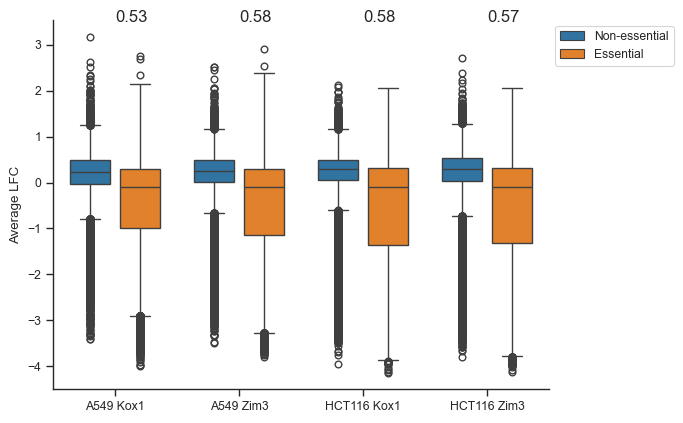

In [70]:
#SSMD

sns.boxplot(data = plot_df, x = 'condition', y = 'Average LFC', hue = 'Category', palette = {'Non-essential':'#1f77b4','Essential':'#ff7f0e'},
            order = ["A549 Kox1","A549 Zim3","HCT116 Kox1","HCT116 Zim3"],gap = 0.2)
plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('')

sns.despine()
for condition in ssmd_df['condition']:
    ssmd = round(float(ssmd_df.loc[ssmd_df['condition'] == condition,'ssmd']),2)
    plt.text(x=condition,y=3.5,s=ssmd,fontsize=12)

gpp.savefig(figure1_outpath+'guide_lfc_boxplot_ssmd.pdf', dpi=300, bbox_inches='tight')

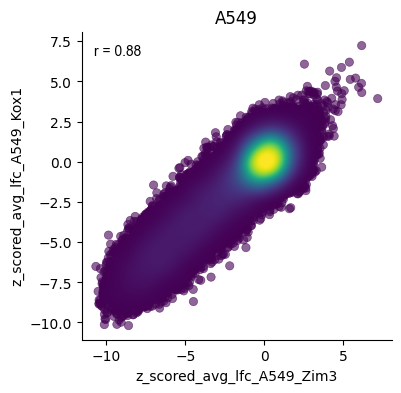

In [9]:
# compare different domains for A549
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=merged_df, x='z_scored_avg_lfc_A549_Zim3', y='z_scored_avg_lfc_A549_Kox1')
gpp.add_correlation(data=merged_df, x='z_scored_avg_lfc_A549_Zim3', y='z_scored_avg_lfc_A549_Kox1')
sns.despine()
plt.title('A549')
plt.savefig(figure1_outpath+'A549_different_domains.pdf',
           dpi=300, bbox_inches='tight')

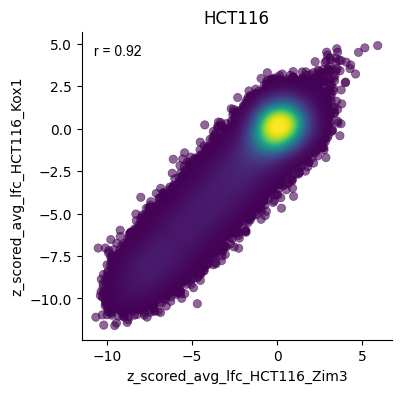

In [10]:
# compare different domains for HCT116
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_HCT116_Kox1')
gpp.add_correlation(data=merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_HCT116_Kox1')
sns.despine()
plt.title('HCT116')
plt.savefig(figure1_outpath+'HCT116_different_domains.pdf',
           dpi=300, bbox_inches='tight')

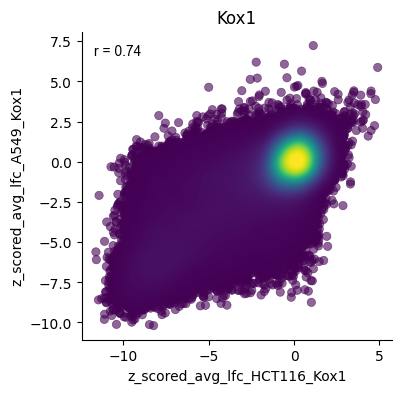

In [11]:
# compare Kox1 and different cell lines using all the data

plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=merged_df, x='z_scored_avg_lfc_HCT116_Kox1', y='z_scored_avg_lfc_A549_Kox1')
gpp.add_correlation(data=merged_df, x='z_scored_avg_lfc_HCT116_Kox1', y='z_scored_avg_lfc_A549_Kox1')
sns.despine()
plt.title('Kox1')
plt.savefig(figure1_outpath+'z-score Kox1 (HCT116 vs A549) scatterplot.pdf',
           dpi=300, bbox_inches='tight')



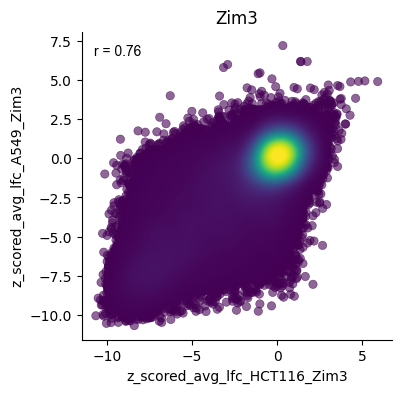

In [12]:
# compare Zim3 and different cell lines using all the data

plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_A549_Zim3')
gpp.add_correlation(data=merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_A549_Zim3')
sns.despine()
plt.title('Zim3')
plt.savefig(figure1_outpath+'z-score Zim3 (HCT116 vs A549) scatterplot.pdf',
           dpi=300, bbox_inches='tight')

# guides targeting essential gene 

In [13]:

# subset df for only using guide targeting esetnial genes
ess_merged_df = merged_df[merged_df['Category'] == 'Essential'].copy()

Text(0.5, 1.0, 'HCT116 (essential genes only)')

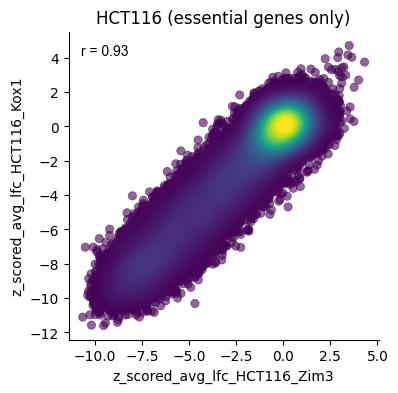

In [15]:
# HCT116
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=ess_merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_HCT116_Kox1')
gpp.add_correlation(data=ess_merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_HCT116_Kox1')
sns.despine()
plt.title('HCT116 (essential genes only)')
plt.savefig('/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/figure/2023/CRISPRi/tiling/z-score HCT116 Kox1 - Zim3 scatterplot.pdf',
           dpi=300, bbox_inches='tight')

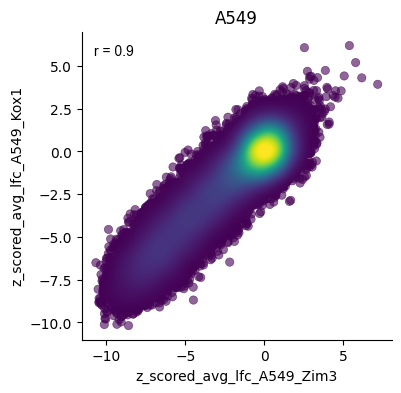

In [16]:
# A549
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=ess_merged_df, x='z_scored_avg_lfc_A549_Zim3', y='z_scored_avg_lfc_A549_Kox1')
gpp.add_correlation(data=ess_merged_df, x='z_scored_avg_lfc_A549_Zim3', y='z_scored_avg_lfc_A549_Kox1')
sns.despine()
plt.title('A549')
plt.savefig(figure1_outpath+'z-score A549 Kox1 - Zim3 scatterplot.pdf',
           dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Ess Kox1')

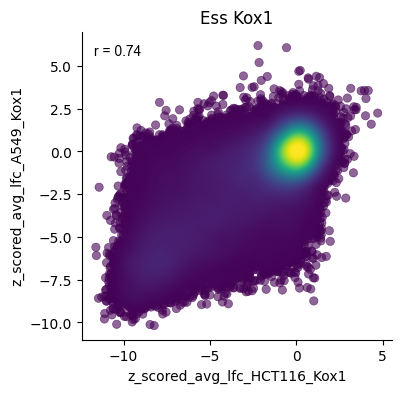

In [17]:
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=ess_merged_df, x='z_scored_avg_lfc_HCT116_Kox1', y='z_scored_avg_lfc_A549_Kox1')
gpp.add_correlation(data=ess_merged_df, x='z_scored_avg_lfc_HCT116_Kox1', y='z_scored_avg_lfc_A549_Kox1')
sns.despine()
plt.title('Ess Kox1')

Text(0.5, 1.0, 'Ess Zim3')

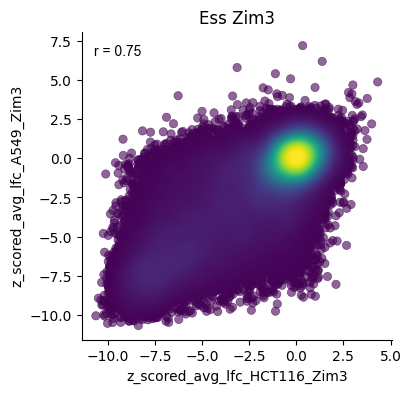

In [18]:
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=ess_merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_A549_Zim3')
gpp.add_correlation(data=ess_merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_A549_Zim3')
sns.despine()
plt.title('Ess Zim3')

# understand how does domain behaves in respect to different cell line

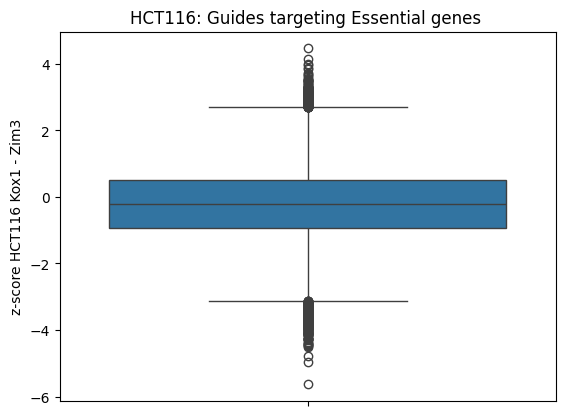

In [19]:
# add columns to understand how does domain behaves in respect to different cell line
ess_merged_df['z-score HCT116 Kox1 - Zim3'] = ess_merged_df['z_scored_avg_lfc_HCT116_Kox1'] - merged_df['z_scored_avg_lfc_HCT116_Zim3']
ess_merged_df['z-score A549 Kox1 - Zim3'] = ess_merged_df['z_scored_avg_lfc_A549_Kox1'] - merged_df['z_scored_avg_lfc_A549_Zim3']

# HCT116
sns.boxplot(y = ess_merged_df['z-score HCT116 Kox1 - Zim3'])
plt.title('HCT116: Guides targeting Essential genes ')
plt.savefig(figure1_outpath + 'z-score HCT116 Kox1 - Zim3.pdf',
            dpi=300, bbox_inches='tight')

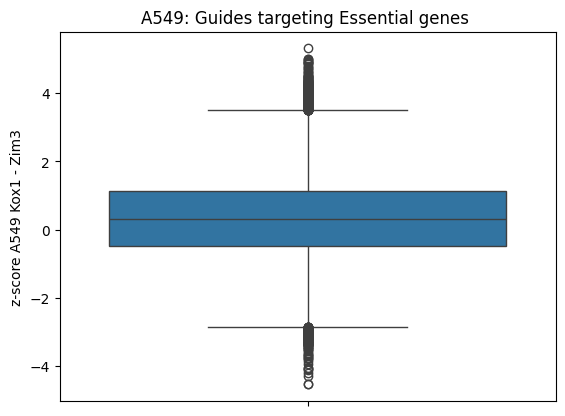

In [20]:
# A549
sns.boxplot(y = ess_merged_df['z-score A549 Kox1 - Zim3'])
plt.title('A549: Guides targeting Essential genes ')
plt.savefig(figure1_outpath + 'z-score A549 Kox1 - Zim3.pdf',
           dpi=300, bbox_inches='tight')

In [21]:
guide_level_domain_comp = ess_merged_df[['z-score HCT116 Kox1 - Zim3', 'z-score A549 Kox1 - Zim3']].copy().melt()


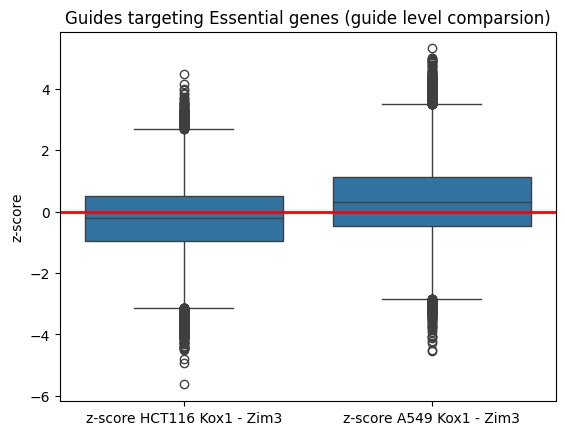

In [22]:
ax = sns.boxplot(data = guide_level_domain_comp, y = 'value', x = 'variable')
ax.axhline(y=0, linewidth=2, color='red', ls='-')
plt.title('Guides targeting Essential genes (guide level comparsion)')
ax.set(xlabel='', ylabel='z-score')
plt.savefig(figure1_outpath + 'z-score cellline Kox1 - Zim3.pdf',
           dpi=300, bbox_inches='tight')

In [23]:
# one sided test for A549 to understand how the t statistics look


mu = 0
mean = np.mean(ess_merged_df['z-score A549 Kox1 - Zim3'])
std_error = np.std(ess_merged_df['z-score A549 Kox1 - Zim3']) / np.sqrt(len(ess_merged_df['z-score A549 Kox1 - Zim3']))

# calculate t statistics
t = abs(mean - mu) / std_error
t

69.28948308021984

In [24]:

stats.ttest_1samp(ess_merged_df['z-score A549 Kox1 - Zim3'], popmean=0.0)

TtestResult(statistic=69.28890133140823, pvalue=0.0, df=59552)

In [25]:
ttest, pval = ttest_ind(ess_merged_df['z_scored_avg_lfc_A549_Kox1'], ess_merged_df['z_scored_avg_lfc_A549_Zim3'], alternative="greater")

print("t-test", '{0:.10f}'.format(ttest))
print("p-value", '{0:.10f}'.format(pval))

t-test 22.3452179758
p-value 0.0000000000


# compares across categories

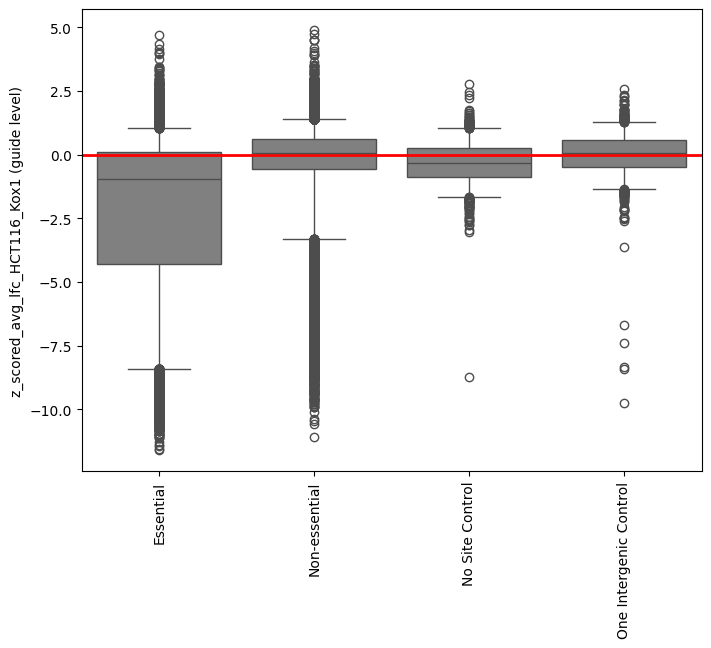

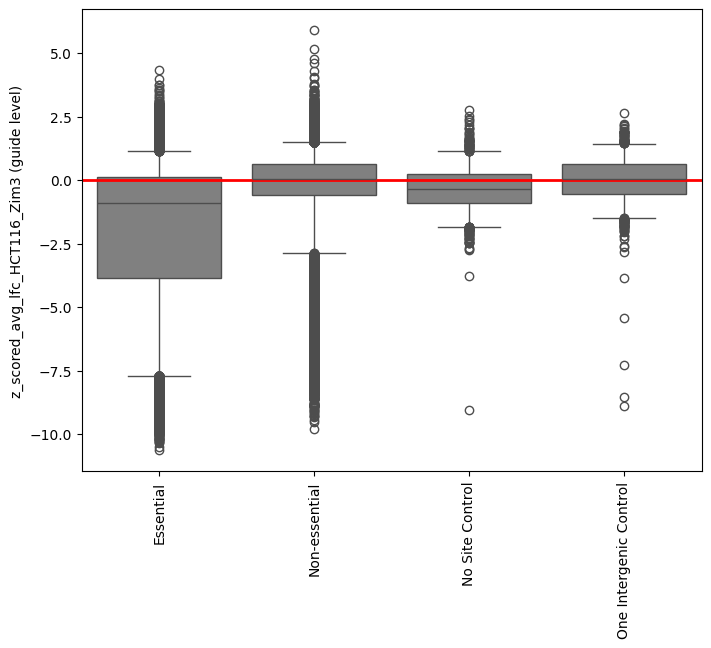

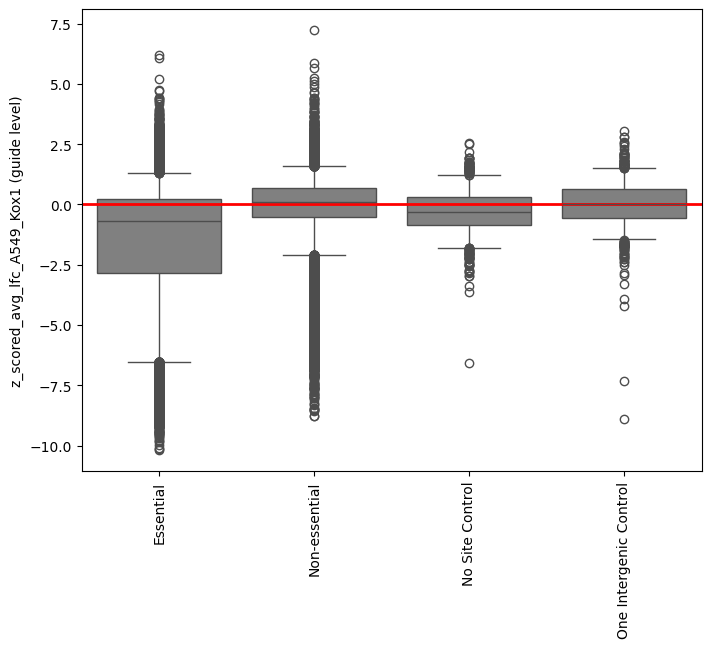

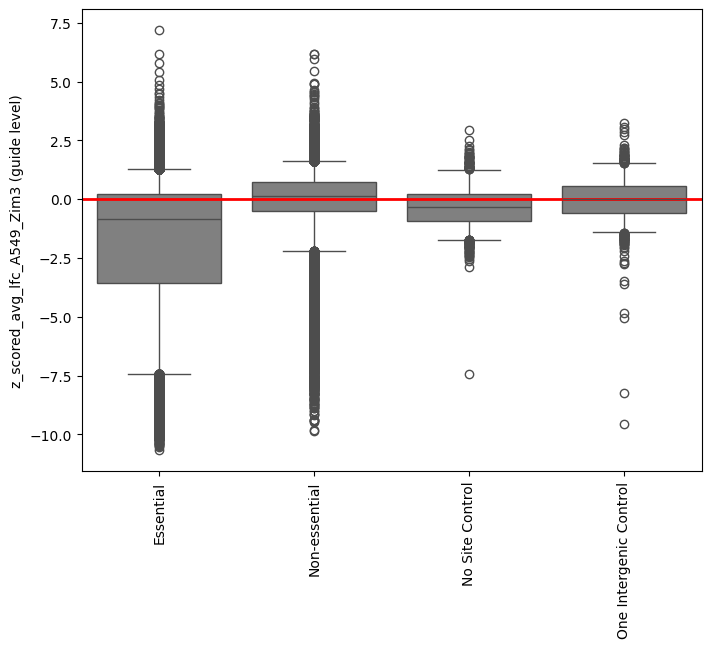

In [26]:
category_order = ['Essential', 'Non-essential', 'No Site Control', 'One Intergenic Control']

for phenotype in ['z_scored_avg_lfc_HCT116_Kox1','z_scored_avg_lfc_HCT116_Zim3','z_scored_avg_lfc_A549_Kox1','z_scored_avg_lfc_A549_Zim3']:
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(data = merged_df, x ='detailedCategory', y=phenotype,
                order=category_order, color = 'grey', whis=[5, 95])
    plt.xlabel('')
    plt.ylabel(phenotype + ' (guide level)')
    plt.xticks(rotation=90)
    ax.axhline(y=0, linewidth=2, color='red', ls='-')# avaerage intergenic control 
    plt.savefig(figure1_outpath + phenotype + ' (guide level)'+'.pdf',
           dpi=300, bbox_inches='tight')
    plt.show()

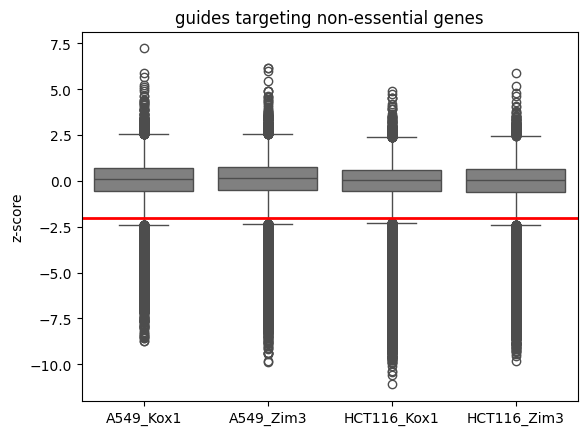

In [27]:
ax = sns.boxplot(data = merged_df[merged_df.Category == 'Non-essential'][['z_scored_avg_lfc_A549_Kox1', 'z_scored_avg_lfc_A549_Zim3',
                                                 'z_scored_avg_lfc_HCT116_Kox1', 'z_scored_avg_lfc_HCT116_Zim3']].rename(columns = {'z_scored_avg_lfc_A549_Kox1': 'A549_Kox1',
                                                                                                                                   'z_scored_avg_lfc_A549_Zim3': 'A549_Zim3',
                                                                                                                                    'z_scored_avg_lfc_HCT116_Kox1': 'HCT116_Kox1',
                                                                                                                                   'z_scored_avg_lfc_HCT116_Zim3': 'HCT116_Zim3'}).melt(),
            x = 'variable',
            y = 'value',
            color = 'grey')
ax.axhline(y=-2, linewidth=2, color='red', ls='-')
plt.xlabel('')
plt.ylabel('z-score')
plt.title('guides targeting non-essential genes')
plt.savefig(figure1_outpath + 'guides targeting non-essential genes'+'.pdf',
           dpi=300, bbox_inches='tight')